In [1]:
import numpy as np
import entropy_estimators as ee
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal
import time
%matplotlib inline

I[x;y] = 0.2075 bits
I[x;y_disc] = [TO DO] bits


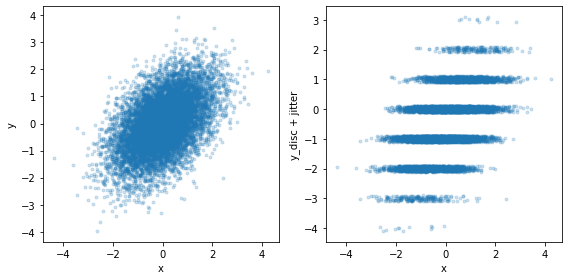

In [2]:
### Generate data
 
# Set parameters
N = 10000 # Number of data points
rho = .5 # Correlation coefficient

# Set mean and variance arrays
mean = np.zeros(2)
cov = np.array([[1, rho],
                [rho, 1]])

# Generate data and extract into x and y
data = multivariate_normal(mean, cov).rvs(N)
x = data[:,0]
y = data[:,1]
y_disc = np.floor(y).astype(int)
y_jitter = y_disc + .2*(np.random.rand(N)-.5)

# Plot simulated data
fig, axs= plt.subplots(1,2,figsize=[8,4])

ax = axs[0]
ax.plot(x,y,'.',alpha=.2)
ax.set_xlabel('x')
ax.set_ylabel('y')

ax = axs[1]
ax.plot(x,y_jitter,'.',alpha=.2)
ax.set_xlabel('x')
ax.set_ylabel('y_disc + jitter')


# Compute theoretical mutual information
I_exact = -0.5*np.log2(1-rho**2)
print(f'I[x;y] = {I_exact:.4f} bits')

# TO DO: Compute exact value for discrete entropy
print(f'I[x;y_disc] = [TO DO] bits')

fig.tight_layout()

In [3]:
def mi_continuous(x, 
                  y, 
                  knn=5, 
                  uncertainty=True, 
                  num_subsamples=25, 
                  use_LNC=False, 
                  alpha_LNC=.5,
                  verbose=False):
    """
    Estimate mutual information between two continuous 
    variables using the KSG estimator, with optional LNC correction. 
    Wrapper for methods in the NPEET package.
    
    parameters
    ----------
    
    x: (array-like of floats)
        Continuous x-values. Must be castable as a 
        Nx1 numpy array where N=len(x).
    
    y: (array-like of floats)
        Continuous y-values. Must be the same length 
        as x and castable as a Nx1 numpy array.
        
    knn: (int>0)
        Number of nearest neighbors to use in the KSG estimator.
        
    uncertainty: (bool)
        Whether to estimate the uncertainty of the MI estimate. 
        Substantially increases runtime if True. 
        
    num_subsamples: (int > 0)
        Number of subsamples to use if estimating uncertainty.
        
    use_LNC: (bool)
        Whether to compute the Local Nonuniform Correction 
        (LNC) using the method of Gao et al., 2015. 
        Substantially increases runtime if True.
        
    alpha_LNC: (float in (0,1))
        Value of alpha to use when computing LNC. 
        See Gao et al., 2015 for details. 
        
    verbose: (bool)
        Whether to print results and execution time. 
        
    returns
    -------
    
    I: (float)
        Mutual information estimate in bits
        
    dI: (float >= 0)
        Uncertainty estimate in bits. Zero if uncertainty=False is set. 
        
    """
    
    # Start timer
    start_time = time.time()
    
    N = len(x)
    assert len(y) == N
    
    # If not LNC_correction, set LNC_alpha=0
    if not use_LNC:
        alpha_LNC=0
    
    # Make sure x and y are 1D arrays
    x = np.array(x).ravel()
    y = np.array(y).ravel()
    
    # Get best I estimate
    I = ee.mi(x, y, k=knn, alpha=alpha_LNC)
    
    # Compute uncertainty if requested
    if uncertainty:
    
        # Do subsampling to get I_subs
        assert num_subsamples >= 2, f'Invalid value for num_subsamples={num_subsamples}'
        I_subs = np.zeros(num_subsamples)
        for k in range(num_subsamples):
            N_half = int(np.floor(N/2))
            ix = np.random.choice(N, size=N_half, replace=False).astype(int)
            x_k = x[ix]
            y_k = y[ix]
            I_subs[k] = ee.mi(x_k, y_k, k=knn, alpha=alpha_LNC)

        # Estimate dI
        dI = np.std(I_subs, ddof=1)/np.sqrt(2)
    
    # Otherwise, just set to zero
    else:
        dI = 0.0
    
    # Get execution time
    t = time.time()-start_time
    
    # If verbose, print results:
    if verbose:
        #print(f'Arguments: knn={knn}, num_subsamples={num_subsamples}')
        print(f'Execution time: {t:.4f} sec')
        print(f'Results: I={I:.4f} bits, dI={dI:.4f} bits')
        
    # Return results
    return I, dI

# Test
mi_continuous(x, y, verbose=True)

Execution time: 0.8888 sec
Results: I=0.2019 bits, dI=0.0088 bits


(0.20190815361133377, 0.008781148846701475)

In [4]:
def mi_mixed(x, 
             y, 
             knn=5, 
             discrete_var='y', 
             uncertainty=True,
             num_subsamples=25, 
             verbose=False, 
             warning=False):
    """
    Estimate mutual information between one continuous 
    variable and one discrete variable using the k'th nearest neighbor estimator. 
    Wrapper for methods in the NPEET package.
    
    parameters
    ----------
    
    x: (array-like)
        Continuous or discrete x-values. Must be castable as a 
        Nx1 numpy array where N=len(x).
    
    y: (array-like)
        Continuous or discrete y-values. Must be the same length 
        as x and castable as a Nx1 numpy array.
        
    knn: (int>0)
        Number of nearest neighbors to use in the KSG estimator.
       
    discrete_var: (str)
        Which variable is discrete. Must be 'x' or 'y'.
       
    uncertainty: (bool)
        Whether to estimate the uncertainty of the MI estimate. 
        Substantially increases runtime if True. 
        
    num_subsamples: (int > 0)
        Number of subsamples to use if estimating uncertainty.
        
    verbose: (bool)
        Whether to print results and execution time. 
        
    returns
    -------
    
    I: (float)
        Mutual information estimate in bits
        
    dI: (float >= 0)
        Uncertainty estimate in bits. Zero if uncertainty=False is set. 
        
    """
    
    # Deal with choice of discrete_var
    assert discrete_var in ['x','y'], f'Invalid value for discrete_var={discrete_var}'
    if discrete_var=='x':
        return mi_mixed(y, x, discrete_var='y', **kwargs)
    
    # Start timer
    start_time = time.time()
    
    N = len(x)
    assert len(y) == N
    
    # Make sure x and y are 1D arrays
    x = np.array(x).reshape(N,1)
    y = np.array(y).reshape(N,1)
    
    # Get best I estimate
    I = ee.micd(x, y, k=knn, warning=warning)
    
    # Compute uncertainty if requested
    if uncertainty:
    
        # Do subsampling to get I_subs
        I_subs = np.zeros(num_subsamples)
        for k in range(num_subsamples):
            N_half = int(np.floor(N/2))
            ix = np.random.choice(N, size=N_half, replace=False).astype(int)
            x_k = x[ix,:]
            y_k = y[ix,:]
            I_subs[k] = ee.micd(x_k, y_k, k=knn, warning=False)

        # Estimate dI
        dI = np.std(I_subs, ddof=1)/np.sqrt(2)

    # Otherwise, just set to zero
    else:
        dI = 0.0
        
    # Get execution time
    t = time.time()-start_time
    
    # If verbose, print results:
    if verbose:
        print(f'Arguments: knn={knn}, num_subsamples={num_subsamples}')
        print(f'Execution time: {t:.4f} sec')
        print(f'Results: I={I:.4f} bits, dI={dI:.4f} bits')
        
    # Return results
    return I, dI

# Test function
mi_mixed(x=x, y=y_disc, discrete_var='y', verbose=True)

Arguments: knn=5, num_subsamples=25
Execution time: 0.5367 sec
Results: I=0.1930 bits, dI=0.0111 bits


(0.1930224982268629, 0.01113338329678956)

In [5]:
def entropy_continuous(x, 
                       knn=5,
                       uncertainty=True,
                       num_subsamples=25, 
                       verbose=False):
    """
    Estimate the entropy of a continuous univariate variable
    using the k'th nearest neighbor estimator. 
    Wrapper for methods in the NPEET package.
    
    parameters
    ----------
    
    x: (array-like of floats)
        Continuous x-values. Must be castable as a 
        Nx1 numpy array where N=len(x).
        
    knn: (int>0)
        Number of nearest neighbors to use in the KSG estimator.
       
    uncertainty: (bool)
        Whether to estimate the uncertainty of the MI estimate. 
        Substantially increases runtime if True. 
        
    num_subsamples: (int > 0)
        Number of subsamples to use if estimating uncertainty.
        
    verbose: (bool)
        Whether to print results and execution time. 
        
    returns
    -------
    
    I: (float)
        Mutual information estimate in bits
        
    dI: (float >= 0)
        Uncertainty estimate in bits. Zero if uncertainty=False is set. 
        
    """
    
    # Start timer
    start_time = time.time()
    
    # Get number of datapoints
    N = len(x)
    
    # Reshape to Nx1 array 
    x = np.array(x).reshape(N,1)
    
    # Get best H estimate
    H = ee.entropy(x,k=knn)
    
    # Do subsampling to get I_subs
    H_subs = np.zeros(num_subsamples)
    for k in range(num_subsamples):
        N_half = int(np.floor(N/2))
        ix = np.random.choice(N, size=N_half, replace=False).astype(int)
        x_k = x[ix,:]
        H_subs[k] = ee.entropy(x_k,k=knn)
        
    # Estimate dI
    dH = np.std(H_subs, ddof=1)/np.sqrt(2)
    
    # Get execution time
    t = time.time()-start_time
    
    # If verbose, print results:
    if verbose:
        print(f'Arguments: knn={knn}, num_subsamples={num_subsamples}')
        print(f'Execution time: {t:.4f} sec')
        print(f'Results: H={H:.4f} bits, dH={dH:.4f} bits')
        
    # Return results
    return H, dH

entropy_continuous(x,verbose=True)

Arguments: knn=5, num_subsamples=25
Execution time: 0.2968 sec
Results: H=2.0393 bits, dH=0.0106 bits


(2.0392978885950566, 0.010568077674622452)

-----

In [6]:
# # Estimate uncertainty
# K = 25
# M = 10
# k_nn = 5
# I_ks = np.zeros(K)
# I_ms = np.zeros(M)
# dI_ms = np.zeros(M)
# ms = np.arange(1,M+1)
# for m in ms:
#     for k in range(K):
#         N_half = int(np.floor(N/m))
#         ix = np.random.choice(N, size=N_half, replace=False).astype(int)
#         x_k = x[ix]
#         y_k = y[ix]
#         I_ks[k] = ee.mi(x_k,y_k,k=k_nn)
#     I_ms[m-1] = np.mean(I_ks)
#     dI_ms[m-1] = np.std(I_ks, ddof=1)/np.sqrt(m)

# fig, ax = plt.subplots(1,1,figsize=[5,5])
    
# ax.errorbar(ms, I_ms, dI_ms)
# ax.set_xlim([0,M])

# sns.distplot(I_ks, bins=30)
        
# #dI_estimated = np.std(I_ks, ddof=1)/np.sqrt(2)
# #print(f'I: {I_estimated:.4f} +- {dI_estimated:.4f} bits')